In [1]:
import minari

minigrid_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
env  = minigrid_dataset.recover_environment()

In [2]:
print("Observation space:", minigrid_dataset.observation_space)
print("Action space:", minigrid_dataset.action_space)
print("Total episodes:", minigrid_dataset.total_episodes)
print("Total steps:", minigrid_dataset.total_steps)

Observation space: Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': Text(1, 14, charset=                                                              ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''(),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdeeeffghijklmnnoopqrrssttuvwxyzz{}))
Action space: Discrete(7)
Total episodes: 590
Total steps: 10010


In [3]:
minigrid_dataset.set_seed(seed=123)

for i in range(5):
    # sample 5 episodes from the dataset
    episodes = minigrid_dataset.sample_episodes(n_episodes=5)
    # get id's from the sampled episodes
    ids = list(map(lambda ep: ep.id, episodes))
    print(f"EPISODE ID'S SAMPLE {i}: {ids}")

EPISODE ID'S SAMPLE 0: [31, 348, 9, 536, 400]
EPISODE ID'S SAMPLE 1: [103, 265, 544, 204, 477]
EPISODE ID'S SAMPLE 2: [302, 158, 14, 505, 522]
EPISODE ID'S SAMPLE 3: [240, 125, 371, 87, 435]
EPISODE ID'S SAMPLE 4: [468, 125, 305, 489, 469]


In [4]:
episodes[0].observations["image"].shape

(11, 7, 7, 3)

In [5]:
from minigrid.core import constants as mgc

In [6]:
def minigrid_to_rgb(obs):
    _obs = torch.zeros(obs.shape, dtype=torch.uint8)
    for i in range(_obs.size(0)):
        for j in range(_obs.size(1)):
            _obs[i, j] = torch.from_numpy(mgc.COLORS[mgc.IDX_TO_COLOR[obs[i, j, 1]]]).to(torch.uint8)
    return _obs.permute(2, 0, 1)

In [11]:
import matplotlib.pyplot as plt
import torch

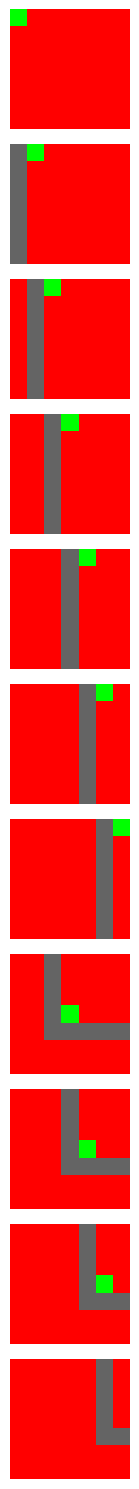

In [12]:
episode = episodes[0]
l = episode.observations["image"].shape[0]
fig, axs = plt.subplots(l, 1, figsize=(15, 15))
for i in range(l):
    axs[i].imshow(minigrid_to_rgb(episode.observations["image"][i]).permute(1, 2, 0))
    axs[i].axis("off")
plt.tight_layout()
plt.show()

In [15]:
import torchvision.transforms.v2 as transforms

In [37]:
image_resize = transforms.Resize((96, 96))

In [38]:
resized_minari_grid_observation_image = image_resize([minigrid_to_rgb(episode.observations["image"][1])])
resized_minari_grid_observation_image[0].shape

torch.Size([3, 96, 96])

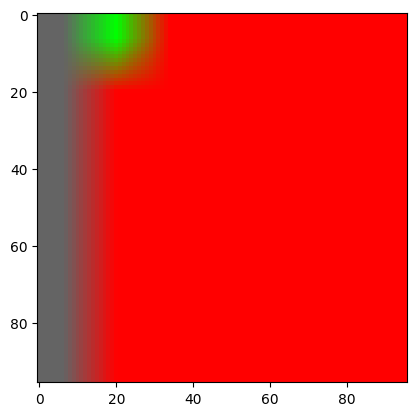

In [39]:
plt.imshow(image_resize([minigrid_to_rgb(episode.observations["image"][1])])[0].permute(1, 2, 0))

In [ ]:
batch = minigrid_dataset.sample_episodes(4)

In [ ]:
# Text embeddings
text_tokens = tokenize_text(sample.observations["mission"], padding="longest", return_tensors="pt")["input_ids"]
text_embeddings = embed_text(text_tokens)
text_mask = torch.zeros(text_embeddings.size(1))

# Visual embeddings
minigrid_images = [minigrid_to_rgb(image) for image in batch[0].observations["image"]]
minigrid_images_resized = [image_resize(image) for image in minigrid_images]
image_tokens = tokenize_image(minigrid_images_resized)
# batch[0].observation["image"] is in numpy format, HxWxC.
# heights, widths = map(torch.tensor, zip(*[image.shape[1:3] for image in batch[0].observations["image"]]))
heights, widths = map(torch.tensor, zip(*[image.shape[1:3] for image in minigrid_images_resized]))
n_patch_rows, n_patch_cols = n_patch_rows_cols(12, 12, heights, widths)
image_embeddings = embed_image(n_patch_rows, n_patch_cols, image_tokens)
image_mask = torch.zeros(image_embeddings.size(1))

# Discrete embeddings
discrete_tokens = torch.from_numpy(sample.observations["direction"])
discrete_embeddings = embed_discrete(discrete_tokens).unsqueeze(dim=1)
discrete_mask = torch.zeros(discrete_embeddings.size(1))

# Separator_embedding
# defined above
separator_mask = torch.zeros(1)

# Action embeddings
action_tokens = torch.from_numpy(sample.actions)
action_embeddings = embed_discrete(action_tokens).unsqueeze(dim=1)
action_mask = torch.ones(action_embeddings.size(1))

observation_sequence_length = len(text_mask) + len(image_mask) + len(discrete_mask) + len(separator_mask) + len(action_mask)

sequence = []
mask = []
for i in range(action_embeddings.size(0)):
    sequence.append(torch.concat([text_embeddings[i], image_embeddings[i], discrete_embeddings[i], separator_embedding[0], action_embeddings[i]]))
    mask.append(torch.concat([text_mask, image_mask, discrete_mask, separator_mask, action_mask]))

# How many episodes can fit in our context window?
max_episodes = int(SEQUENCE_LENGTH // len(sequence[0]))

# Pick a random episode to start from, and take up to max.
offset = random.randint(0, len(sequence) - max_episodes // 2)

sequence = torch.concat(sequence)
mask = torch.concat(mask)

sequence = sequence[offset*observation_sequence_length : (offset+max_episodes)*observation_sequence_length]
mask = mask[offset*observation_sequence_length : (offset+max_episodes)*observation_sequence_length]

if len(sequence) < SEQUENCE_LENGTH:
    mask = torch.concat([mask, torch.zeros(SEQUENCE_LENGTH - len(mask))])
    padding = torch.zeros((SEQUENCE_LENGTH - len(sequence), *sequence.shape[1:]))
    sequence = torch.concat([sequence, padding])